<a href="https://colab.research.google.com/github/sergioGarcia91/ML_Carolina_Bays/blob/main/15d_U_Net_v2_7chanels_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Start

In [ ]:
!pip install tables

In [ ]:
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import h5py
import multiprocessing
import joblib

from sklearn.model_selection import train_test_split

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

# Verificar si CUDA (GPU) está disponible
if torch.cuda.is_available():
    print(f"GPU disponible: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    print("GPU no disponible, usando CPU.")

GPU disponible: NVIDIA A100-SXM4-40GB


In [ ]:
device

device(type='cuda')

In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Change Font of the Figures

In [ ]:
!wget https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman.ttf

--2025-06-16 18:42:09--  https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman.ttf
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/justrajdeep/fonts/master/Times%20New%20Roman.ttf [following]
--2025-06-16 18:42:09--  https://raw.githubusercontent.com/justrajdeep/fonts/master/Times%20New%20Roman.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 834452 (815K) [application/octet-stream]
Saving to: ‘Times New Roman.ttf’

Times New Roman.ttf 100%[===================>] 814.89K  --.-KB/s    in 0.06s   

2025-06-16 18:42:09 (14.3 MB/s) - ‘Times New Roman.ttf’ saved [834452/834452]



In [ ]:
import matplotlib.font_manager as fm

In [ ]:
# Path to the custom font
font_path = 'Times New Roman.ttf'

# Add the font to the Matplotlib font manager
font_prop = fm.FontProperties(fname=font_path)
fm.fontManager.addfont(font_path)

# Get the font name to use in rcParams
font_name = font_prop.get_name()
font_name

'Times New Roman'

In [ ]:
plt.rcParams['font.family'] = font_name

# Funtions

In [ ]:
def normalized_index(B1, B2):
  x = (B2 - B1) / (B2 + B1)
  x = np.nan_to_num(x, nan=0.0, posinf= 1.0)
  x = (x + 1 ) / 2
  x = np.expand_dims(x, axis=1)
  return x


In [ ]:
# ChatGPT

def normalized_index(B1, B2, epsilon=1e-8):
    # Añadir una pequeña constante al denominador para evitar la división por cero
    denominator = B2 + B1 + epsilon
    x = (B2 - B1) / denominator
    # Sustituir NaN y valores infinitos
    x = np.nan_to_num(x, nan=0.0, posinf=1.0, neginf=-1.0)
    # Normalizar entre 0 y 1
    x = (x + 1) / 2
    # Expande las dimensiones si es necesario
    x = np.expand_dims(x, axis=1)
    return x


## U-NET v2

https://medium.com/data-science/cook-your-first-u-net-in-pytorch-b3297a844cf3

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu

In [ ]:
class UNet_v2(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image.
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 256x256x7
        #self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # output: 570x570x64
        self.e11 = nn.Conv2d(7, 64, kernel_size=3, padding=1) # output: 570x570x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 282x282x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 138x138x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 66x66x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input: 32x32x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 30x30x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 28x28x1024


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))

        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

# Load Data

In [ ]:
path_save_h5 = '/content/drive/MyDrive/UIS/Doctorado_UIS2198589/1_semestre/TopicosAvanzadosGeofisica/FC_CarolinaBais/Dataset_h5'

h5_file = os.listdir(path_save_h5)
h5_file

['dataset_AOI_01_32x32.h5',
 'dataset_AOI_02_32x32.h5',
 'dataset_AOI_03_32x32.h5',
 'dataset_AOI_04_32x32.h5',
 'dataset_AOI_02_64x64.h5',
 'dataset_AOI_01_64x64.h5',
 'dataset_AOI_03_64x64.h5',
 'dataset_AOI_04_64x64.h5',
 'dataset_AOI_02_256x256.h5',
 'dataset_AOI_03_256x256.h5',
 'dataset_AOI_04_256x256.h5',
 'dataset_AOI_01_256x256.h5']

In [ ]:
# Abrir archivo en modo lectura
with h5py.File(os.path.join(path_save_h5,'dataset_AOI_01_256x256.h5'), 'r') as f:
    # Ver todas las claves del archivo (datasets o grupos)
    print("Keys:", list(f.keys()))

    # Acceder a un dataset específico
    data_X_1 = f['AOI_01_X'][::3]
    data_y_1 = f['AOI_01_y'][::3]
    print(data_X_1.shape, data_y_1.shape)

# Abrir archivo en modo lectura
with h5py.File(os.path.join(path_save_h5,'dataset_AOI_03_256x256.h5'), 'r') as f:
    # Ver todas las claves del archivo (datasets o grupos)
    print("Keys:", list(f.keys()))

    # Acceder a un dataset específico
    data_X_2 = f['AOI_03_X'][::3]
    data_y_2 = f['AOI_03_y'][::3]
    print(data_X_2.shape, data_y_2.shape)

data_X = np.concatenate((data_X_1, data_X_2), axis=0)
data_y = np.concatenate((data_y_1, data_y_2), axis=0)
print(data_X.shape, data_y.shape)

Keys: ['AOI_01_FC_percentaje', 'AOI_01_X', 'AOI_01_y']
(5040, 7, 256, 256) (5040, 256, 256)
Keys: ['AOI_03_FC_percentaje', 'AOI_03_X', 'AOI_03_y']
(5040, 7, 256, 256) (5040, 256, 256)
(10080, 7, 256, 256) (10080, 256, 256)


In [ ]:
data_X.shape, data_y.shape

((10080, 7, 256, 256), (10080, 256, 256))

In [ ]:
del data_X_2, data_y_2, data_X_1, data_y_1

## New channels

In [ ]:
# B3 --> axis 2
# B6 --> axis 5
# B4_B1 --> axis 7
data_X = np.concatenate((data_X, normalized_index(data_X[:, 0, :, :], data_X[:, 3, :, :])), axis=1)

# B4_B3 --> axis 8
data_X = np.concatenate((data_X, normalized_index(data_X[:, 2, :, :], data_X[:, 3, :, :])), axis=1)

# B7_B3 --> axis 9
data_X = np.concatenate((data_X, normalized_index(data_X[:, 2, :, :], data_X[:, 6, :, :])), axis=1)

# B6_B4 --> axis 10
data_X = np.concatenate((data_X, normalized_index(data_X[:, 3, :, :], data_X[:, 5, :, :])), axis=1)

# B6_B5 --> axis 11
data_X = np.concatenate((data_X, normalized_index(data_X[:, 4, :, :], data_X[:, 5, :, :])), axis=1)

data_X.shape

(10080, 12, 256, 256)

In [ ]:
# Tomar las 7 bandas de interes segun los otros algoritmos Reg Log y Rand Forest
data_X = data_X[:,[2, 5, 7 , 8, 9, 10, 11],:,:]
data_X.shape

(10080, 7, 256, 256)

## Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_X,
                                                    data_y,
                                                    test_size=0.2,
                                                    random_state=42)

In [ ]:
X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train).unsqueeze(1).float()  # añade canal, y asegúrate de tipo float

print(X_train.shape, y_train.shape)

torch.Size([8064, 7, 256, 256]) torch.Size([8064, 1, 256, 256])


In [ ]:
X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test).unsqueeze(1).float()  # añade canal, y asegúrate de tipo float#, dtype=torch.long).squeeze()

print(X_test.shape, y_test.shape)

torch.Size([2016, 7, 256, 256]) torch.Size([2016, 1, 256, 256])


In [ ]:
# Agrupar en un dataset
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [ ]:
BATCH_SIZE = 100 #256
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,# 32 con CPU GPU 01... 256 con GPU 02
                          shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,# 32 con CPU GPU 01 ... 256 con GPU 02
                         shuffle=False, num_workers=2)

In [ ]:
#torch.cuda.empty_cache()  # Liberar la memoria no utilizada

## Train

In [ ]:
# import the necessary packages
#from pyimagesearch.dataset import SegmentationDataset
#from pyimagesearch.model import UNet
#from pyimagesearch import config
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import time
import os

In [ ]:
lr_unet = 0.00005 # 0.0001

# initialize our UNet model
n_class = 1  # Ajusta esto al número de clases de salida que tengas
unet = UNet_v2(n_class=n_class).to(device)
# initialize loss function and optimizer
lossFunc = BCEWithLogitsLoss() # Si estás haciendo segmentación binaria, pon n_class = 1 y usa BCEWithLogitsLoss.
opt = Adam(unet.parameters(), lr=lr_unet)
# calculate steps per epoch for training and test set
trainSteps = len(train_dataset) // BATCH_SIZE
testSteps = len(test_dataset) // BATCH_SIZE

# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

In [ ]:
NUM_EPOCHS = 50 #400

# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(NUM_EPOCHS)):
	# set the model in training mode
	unet.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0
	# loop over the training set
	for (i, (x, y)) in enumerate(train_loader):
		# send the input to the device
		(x, y) = (x.to(device), y.to(device))
		# perform a forward pass and calculate the training loss
		pred = unet(x)
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		unet.eval()
		# loop over the validation set
		for (x, y) in test_loader:
			# send the input to the device
			(x, y) = (x.to(device), y.to(device))
			# make the predictions and calculate the validation loss
			pred = unet(x)
			totalTestLoss += lossFunc(pred, y)
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print("Train loss: {:.6f}, Test loss: {:.4f}".format(
		avgTrainLoss, avgTestLoss))
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

[INFO] training the network...


  2%|▏         | 1/50 [00:51<42:01, 51.45s/it]

[INFO] EPOCH: 1/50
Train loss: 0.517815, Test loss: 0.3807


  4%|▍         | 2/50 [01:42<41:09, 51.44s/it]

[INFO] EPOCH: 2/50
Train loss: 0.362946, Test loss: 0.3588


  6%|▌         | 3/50 [02:34<40:19, 51.48s/it]

[INFO] EPOCH: 3/50
Train loss: 0.313355, Test loss: 0.3031


  8%|▊         | 4/50 [03:25<39:29, 51.50s/it]

[INFO] EPOCH: 4/50
Train loss: 0.294223, Test loss: 0.2997


 10%|█         | 5/50 [04:17<38:38, 51.52s/it]

[INFO] EPOCH: 5/50
Train loss: 0.281597, Test loss: 0.2818


 12%|█▏        | 6/50 [05:09<37:46, 51.51s/it]

[INFO] EPOCH: 6/50
Train loss: 0.280372, Test loss: 0.2759


 14%|█▍        | 7/50 [06:00<36:56, 51.54s/it]

[INFO] EPOCH: 7/50
Train loss: 0.266483, Test loss: 0.2761


 16%|█▌        | 8/50 [06:52<36:04, 51.55s/it]

[INFO] EPOCH: 8/50
Train loss: 0.249348, Test loss: 0.2288


 18%|█▊        | 9/50 [07:43<35:13, 51.54s/it]

[INFO] EPOCH: 9/50
Train loss: 0.214834, Test loss: 0.1922


 20%|██        | 10/50 [08:35<34:20, 51.52s/it]

[INFO] EPOCH: 10/50
Train loss: 0.180740, Test loss: 0.1729


 22%|██▏       | 11/50 [09:26<33:28, 51.49s/it]

[INFO] EPOCH: 11/50
Train loss: 0.158131, Test loss: 0.1704


 24%|██▍       | 12/50 [10:18<32:36, 51.49s/it]

[INFO] EPOCH: 12/50
Train loss: 0.285045, Test loss: 0.2812


 26%|██▌       | 13/50 [11:09<31:45, 51.49s/it]

[INFO] EPOCH: 13/50
Train loss: 0.245571, Test loss: 0.2057


 28%|██▊       | 14/50 [12:01<30:53, 51.48s/it]

[INFO] EPOCH: 14/50
Train loss: 0.181018, Test loss: 0.1668


 30%|███       | 15/50 [12:52<30:02, 51.49s/it]

[INFO] EPOCH: 15/50
Train loss: 0.150359, Test loss: 0.1401


 32%|███▏      | 16/50 [13:44<29:11, 51.51s/it]

[INFO] EPOCH: 16/50
Train loss: 0.136251, Test loss: 0.1327


 34%|███▍      | 17/50 [14:35<28:19, 51.49s/it]

[INFO] EPOCH: 17/50
Train loss: 0.121679, Test loss: 0.1151


 36%|███▌      | 18/50 [15:26<27:26, 51.46s/it]

[INFO] EPOCH: 18/50
Train loss: 0.111280, Test loss: 0.1144


 38%|███▊      | 19/50 [16:18<26:34, 51.45s/it]

[INFO] EPOCH: 19/50
Train loss: 0.107534, Test loss: 0.1016


 40%|████      | 20/50 [17:09<25:43, 51.44s/it]

[INFO] EPOCH: 20/50
Train loss: 0.098015, Test loss: 0.0964


 42%|████▏     | 21/50 [18:01<24:51, 51.45s/it]

[INFO] EPOCH: 21/50
Train loss: 0.094726, Test loss: 0.0949


 44%|████▍     | 22/50 [18:52<24:00, 51.45s/it]

[INFO] EPOCH: 22/50
Train loss: 0.089362, Test loss: 0.0888


 46%|████▌     | 23/50 [19:44<23:08, 51.44s/it]

[INFO] EPOCH: 23/50
Train loss: 0.085169, Test loss: 0.0849


 48%|████▊     | 24/50 [20:35<22:17, 51.43s/it]

[INFO] EPOCH: 24/50
Train loss: 0.083249, Test loss: 0.0829


 50%|█████     | 25/50 [21:27<21:26, 51.45s/it]

[INFO] EPOCH: 25/50
Train loss: 0.081698, Test loss: 0.0829


 52%|█████▏    | 26/50 [22:18<20:34, 51.45s/it]

[INFO] EPOCH: 26/50
Train loss: 0.077560, Test loss: 0.0778


 54%|█████▍    | 27/50 [23:09<19:42, 51.42s/it]

[INFO] EPOCH: 27/50
Train loss: 0.077541, Test loss: 0.0779


 56%|█████▌    | 28/50 [24:01<18:50, 51.40s/it]

[INFO] EPOCH: 28/50
Train loss: 0.073813, Test loss: 0.0738


 58%|█████▊    | 29/50 [24:52<17:59, 51.43s/it]

[INFO] EPOCH: 29/50
Train loss: 0.211792, Test loss: 0.1534


 60%|██████    | 30/50 [25:44<17:08, 51.44s/it]

[INFO] EPOCH: 30/50
Train loss: 0.111343, Test loss: 0.0894


 62%|██████▏   | 31/50 [26:35<16:17, 51.46s/it]

[INFO] EPOCH: 31/50
Train loss: 0.084776, Test loss: 0.0789


 64%|██████▍   | 32/50 [27:27<15:26, 51.47s/it]

[INFO] EPOCH: 32/50
Train loss: 0.078244, Test loss: 0.0750


 66%|██████▌   | 33/50 [28:18<14:35, 51.48s/it]

[INFO] EPOCH: 33/50
Train loss: 0.073228, Test loss: 0.0726


 68%|██████▊   | 34/50 [29:10<13:43, 51.49s/it]

[INFO] EPOCH: 34/50
Train loss: 0.071325, Test loss: 0.0716


 70%|███████   | 35/50 [30:01<12:52, 51.49s/it]

[INFO] EPOCH: 35/50
Train loss: 0.069545, Test loss: 0.0697


 72%|███████▏  | 36/50 [30:53<12:00, 51.49s/it]

[INFO] EPOCH: 36/50
Train loss: 0.068293, Test loss: 0.0683


 74%|███████▍  | 37/50 [31:44<11:09, 51.49s/it]

[INFO] EPOCH: 37/50
Train loss: 0.067242, Test loss: 0.0691


 76%|███████▌  | 38/50 [32:36<10:17, 51.49s/it]

[INFO] EPOCH: 38/50
Train loss: 0.066981, Test loss: 0.0662


 78%|███████▊  | 39/50 [33:27<09:26, 51.48s/it]

[INFO] EPOCH: 39/50
Train loss: 0.065285, Test loss: 0.0658


 80%|████████  | 40/50 [34:19<08:34, 51.49s/it]

[INFO] EPOCH: 40/50
Train loss: 0.064692, Test loss: 0.0677


 82%|████████▏ | 41/50 [35:10<07:43, 51.48s/it]

[INFO] EPOCH: 41/50
Train loss: 0.064032, Test loss: 0.0638


 84%|████████▍ | 42/50 [36:02<06:51, 51.49s/it]

[INFO] EPOCH: 42/50
Train loss: 0.063747, Test loss: 0.0642


 86%|████████▌ | 43/50 [36:53<06:00, 51.47s/it]

[INFO] EPOCH: 43/50
Train loss: 0.063518, Test loss: 0.0634


 88%|████████▊ | 44/50 [37:44<05:08, 51.48s/it]

[INFO] EPOCH: 44/50
Train loss: 0.062511, Test loss: 0.0631


 90%|█████████ | 45/50 [38:36<04:17, 51.48s/it]

[INFO] EPOCH: 45/50
Train loss: 0.061970, Test loss: 0.0639


 92%|█████████▏| 46/50 [39:27<03:25, 51.47s/it]

[INFO] EPOCH: 46/50
Train loss: 0.062451, Test loss: 0.0616


 94%|█████████▍| 47/50 [40:19<02:34, 51.49s/it]

[INFO] EPOCH: 47/50
Train loss: 0.060772, Test loss: 0.0610


 96%|█████████▌| 48/50 [41:10<01:43, 51.51s/it]

[INFO] EPOCH: 48/50
Train loss: 0.061665, Test loss: 0.0610


 98%|█████████▊| 49/50 [42:02<00:51, 51.49s/it]

[INFO] EPOCH: 49/50
Train loss: 0.060129, Test loss: 0.0607


100%|██████████| 50/50 [42:53<00:00, 51.48s/it]

[INFO] EPOCH: 50/50
Train loss: 0.059358, Test loss: 0.0609
[INFO] total time taken to train the model: 2573.97s


In [ ]:
pathSavePlots = '/content/drive/MyDrive/UIS/Doctorado_UIS2198589/1_semestre/TopicosAvanzadosGeofisica/FC_CarolinaBais/Figures_Models/'

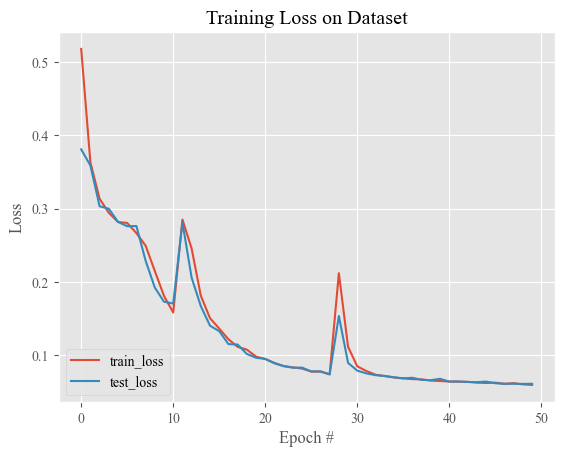

In [ ]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

plt.savefig(pathSavePlots + f'Training_Unet_v2_7ch_ML_GPU_01.png',
            dpi=500,
            bbox_inches = 'tight',
            pad_inches=0.25)

# serialize the model to disk
#torch.save(unet, config.MODEL_PATH)

# Save model

In [ ]:
path_save_models = '/content/drive/MyDrive/UIS/Doctorado_UIS2198589/1_semestre/TopicosAvanzadosGeofisica/FC_CarolinaBais/ML_models/'
name_model = 'model_Unet_v2_7ch_ML_GPU_01.pth' #

# serialize the model to disk
#torch.save(unet, config.MODEL_PATH)
torch.save(unet.state_dict(), path_save_models + name_model)

In [ ]:
os.listdir('/content/drive/MyDrive/UIS/Doctorado_UIS2198589/1_semestre/TopicosAvanzadosGeofisica/FC_CarolinaBais/ML_models')

['model_RegLog_002.pkl',
 'model_RegLog_003.pkl',
 'model_RegLog_004.pkl',
 'model_RegLog_005.pkl',
 'model_RegLog_006.pkl',
 'model_RegLog_007.pkl',
 'model_RegLog_008.pkl',
 'model_RegLog_009.pkl',
 'model_RegLog_010.pkl',
 'model_RegLog_001.pkl',
 'model_RegLog_011.pkl',
 'model_RegLog_012.pkl',
 'model_RegLog_013.pkl',
 'model_RegLog_014.pkl',
 'model_RegLog_015.pkl',
 'model_RegLog_016.pkl',
 'model_RegLog_017.pkl',
 'model_RegLog_018.pkl',
 'model_RegLog_019.pkl',
 'model_RegLog_020.pkl',
 'model_RegLog_021.pkl',
 'model_RegLog_022.pkl',
 'model_RegLog_023.pkl',
 'model_RegLog_024.pkl',
 'model_RegLog_025.pkl',
 'model_RegLog_026.pkl',
 'model_RegLog_027.pkl',
 'model_RegLog_028.pkl',
 'model_RegLog_029.pkl',
 'model_RegLog_030.pkl',
 'df_30models_LogReg.csv',
 'model_RandForest_001.pkl',
 'model_RandForest_002.pkl',
 'model_RandForest_003.pkl',
 'model_RandForest_004.pkl',
 'model_RandForest_005.pkl',
 'model_RandForest_006.pkl',
 'model_RandForest_007.pkl',
 'model_RandForest_0

# End